In [10]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy import ndimage
import math

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams.update({'font.size': 13})



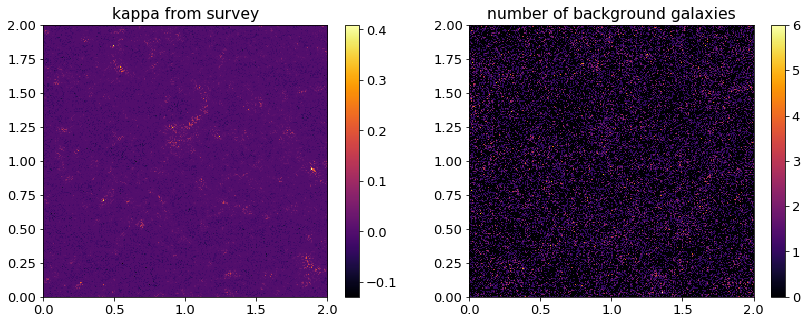

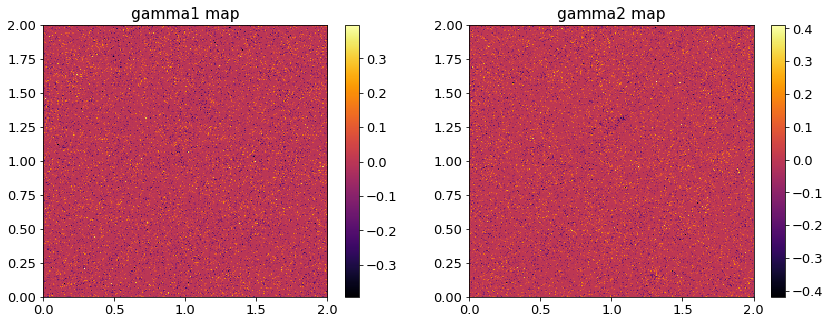

In [11]:
# load survey
x = fits.open('../micev1_dec2/mice2389_cat_nomask_dec2.fits')

npix = 256
    
# read survey data 
kappa_cat = x[1].data.field('kappa').astype(float)
ra=x[1].data.field('ra_gal')
dec = x[1].data.field('dec_gal')
e1 = -x[1].data.field('e1_gal_noise').astype(float)
e2 =  x[1].data.field('e2_gal_noise').astype(float)

# calculate true kappa map from catalogue
fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
kappa_weighted, _, _, cax1 = ax1.hist2d(ra, (np.rad2deg(np.sin(np.deg2rad(dec)))), weights = ((kappa_cat)),bins = (npix,npix), cmap = 'inferno')
ax1.set_title('kappa from survey'), plt.colorbar(cax1, ax=ax1)
number_map, _, _, cax2 = plt.hist2d(ra, (np.rad2deg(np.sin(np.deg2rad(dec)))), bins = (npix, npix), cmap = 'inferno')
ax2.set_title('number of background galaxies'), plt.colorbar(cax2, ax=ax2)

# this division insert nans because many pixels have zero galaxies
kappa_map_true = np.divide(kappa_weighted, number_map, out=np.zeros_like(kappa_weighted), where=number_map!=0).T

# calculate the true g1 and g2 maps from the calalogue for KS
fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
g1_bin, _, _, cax1 = ax1.hist2d(ra, (np.rad2deg(np.sin(np.deg2rad(dec)))), weights = ((e1)),bins = (npix,npix), cmap = 'inferno')
ax1.set_title('gamma1 map'), plt.colorbar(cax1, ax=ax1)
g2_bin, _, _, cax2 = ax2.hist2d(ra, (np.rad2deg(np.sin(np.deg2rad(dec)))), weights = ((e2)),bins = (npix,npix), cmap = 'inferno')
ax2.set_title('gamma2 map'), plt.colorbar(cax2, ax=ax2)

# this division inserts nans because many pixels have zero galaxies
g1_map_true = np.divide(g1_bin, number_map, out=np.zeros_like(g1_bin), where=number_map!=0) 
g2_map_true = np.divide(g2_bin, number_map, out=np.zeros_like(g2_bin), where=number_map!=0) 

plt.show()

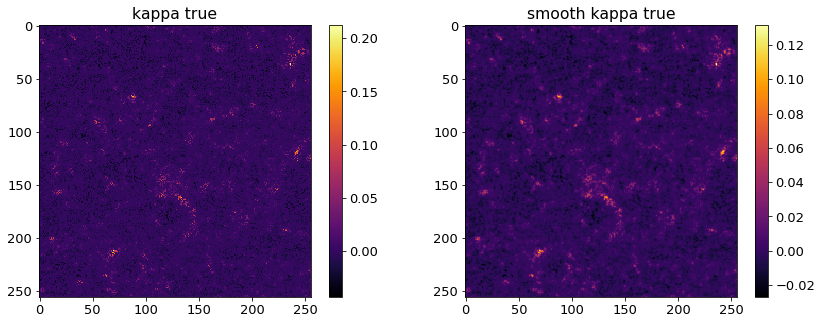

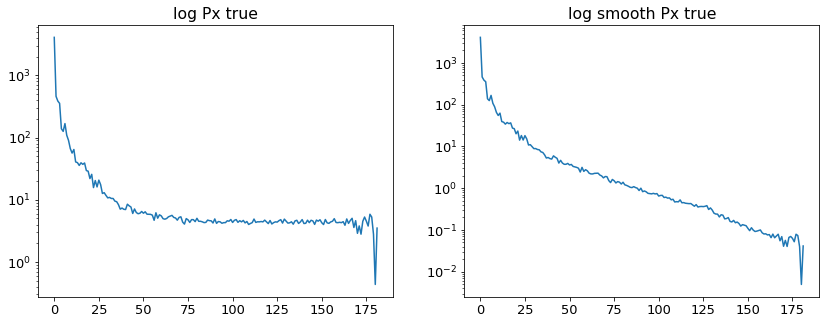

In [13]:
# Compute the power spectrum of true kappa map

def radial_profile(data):
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

# smooth maps
skmt = ndimage.filters.gaussian_filter(kappa_map_true, sigma = .6)

# plot the smooth glimpse, wiener, glimpse+wiener maps
fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].imshow(kappa_map_true, interpolation='none', cmap='inferno')
ax[0].set_title('kappa true'), plt.colorbar(cax1, ax=ax[0])
cax2 = ax[1].imshow(skmt, interpolation='none', cmap='inferno')
ax[1].set_title('smooth kappa true'), plt.colorbar(cax2, ax=ax[1])

fft2D = np.fft.fft2(skmt)
psd1D_skmt = radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))

fft2D = np.fft.fft2(kappa_map_true)
psd1D_kmt = radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))

fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].plot(psd1D_kmt), ax[0].set_title('log Px true'), ax[0].set_yscale('log')
cax2 = ax[1].plot(psd1D_skmt), ax[1].set_title('log smooth Px true'), ax[1].set_yscale('log')

# save spectra as fits file
# hdu_kappa = fits.PrimaryHDU(psd1D_skmt)
# hdul_kappa = fits.HDUList([hdu_kappa])
# hdul_kappa.writeto('../micev1_dec2/Ps1d_kappa_smooth.fits')


In [14]:

# Kaiser-Squares inversion 

def ks93(g1map, g2map):
    """
    Compute Kaiser-Squires inversion convergence maps from binned shear maps.
    Return E-mode and B-mode kappa maps.
    """
    # g1map and g2map should be the same size
    (nx, ny) = g1map.shape

    # Compute Fourier space grid
    # Note: need to reverse the order of nx, ny to achieve proper k1, k2 shapes
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of g1 and g2
    g1hat = np.fft.fft2(g1map)
    g2hat = np.fft.fft2(g2map)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    kEhat = (p1 * g1hat + p2 * g2hat) / k2
    kBhat = -(p2 * g1hat - p1 * g2hat) / k2

    # Transform back to real space
    kEmap = np.fft.ifft2(kEhat).real
    kBmap = np.fft.ifft2(kBhat).real

    return kEmap, kBmap

# compute the Kaiser-Squares map
kks, kksi = ks93(g1_map_true, g2_map_true)
kks = kks.T
ksks = ndimage.filters.gaussian_filter(kks, sigma = 1)
# fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kks.T, interpolation='none', cmap='inferno') 
# ax1.set_title('kappa Kaiser-Squares real'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kksi.T, interpolation='none', cmap='inferno') 
# ax2.set_title('kappa Kaiser-Squares imag'), plt.colorbar(cax2, ax=ax2)

# plt.show()


## View results

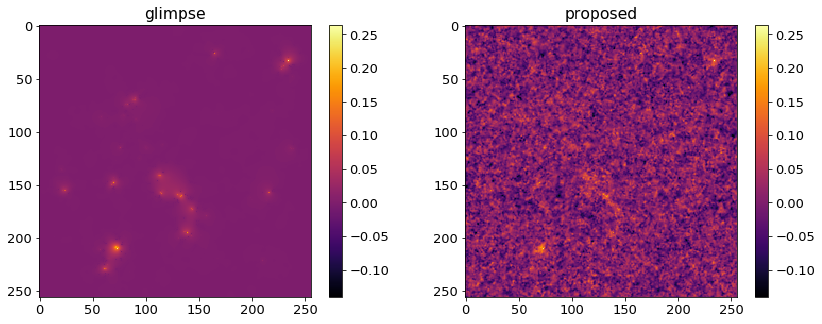

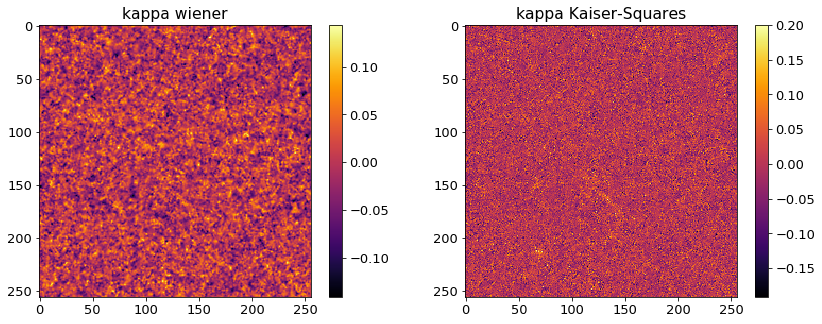

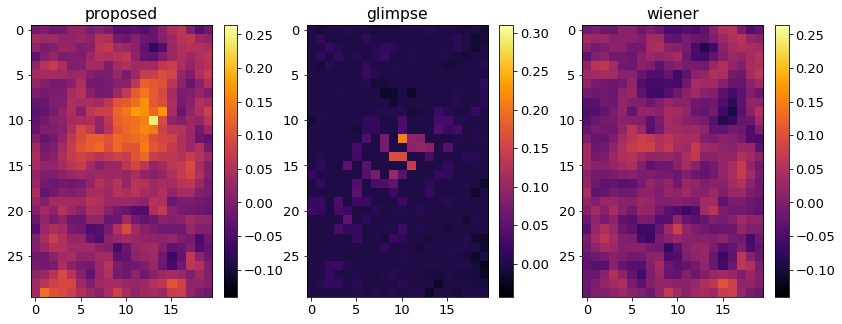

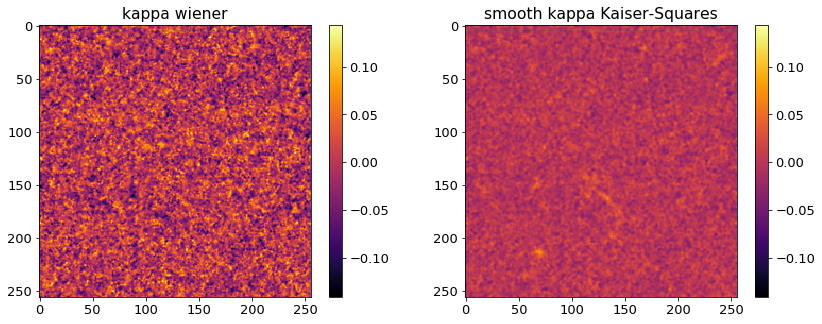

In [15]:
# Plot wiener, KS maps

# read c++ output
kgw = fits.getdata('../build/glpluswf.fits')
kgl = fits.getdata('../build/kglimpse.fits')
kwf = fits.getdata('../build/kwiener.fits')

#  plot the glimpse, wiener, glimpse+wiener maps
fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kgl, interpolation='none', cmap='inferno', vmin= np.min(kwf) , vmax= np.max(kgl)) 
ax1.set_title('glimpse'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kgw, interpolation='none', cmap='inferno',vmin= np.min(kwf) , vmax= np.max(kgl)) 
ax2.set_title('proposed'), plt.colorbar(cax2, ax=ax2)

fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kwf, interpolation='none', cmap='inferno') # , vmin= -np.max(kwf) 
ax1.set_title('kappa wiener'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kks, interpolation='none', cmap='inferno') 
ax2.set_title('kappa Kaiser-Squares'), plt.colorbar(cax2, ax=ax2)

fig3, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(5)
cax1 = ax1.imshow(kgw[200:230,60:80] , interpolation='none', cmap='inferno', vmin= np.min(kwf) , vmax= np.max(kgl)) # , vmin= -np.max(kwf) 
ax1.set_title('proposed'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kappa_map_true[200:230,60:80], interpolation='none', cmap='inferno', vmin= np.min(kappa_map_true) , vmax= .31 ) 
ax2.set_title('glimpse'), plt.colorbar(cax2, ax=ax2)
cax3 = ax3.imshow(kwf[200:230,60:80], interpolation='none', cmap='inferno', vmin= np.min(kwf) , vmax= np.max(kgl)) # , vmin= -np.max(kwf) 
ax3.set_title('wiener'), plt.colorbar(cax3, ax=ax3)

fig4, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kwf, interpolation='none', cmap='inferno' ) # , vmin= -np.max(kwf) 
ax1.set_title('kappa wiener'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(ksks, interpolation='none', cmap='inferno', vmin= np.min(kwf), vmax= np.max(kwf)) 
ax2.set_title('smooth kappa Kaiser-Squares'), plt.colorbar(cax2, ax=ax2)

plt.show()


In [ ]:
# plot the power spectrum of the wiener and smooth KS

fft2D = np.fft.fft2(kwf)
psd1D_kwf = radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))
fft2D = np.fft.fft2(kks)
psd1D_kmt = radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))

fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].plot(psd1D_kwf[1:]), ax[0].set_title('log Px true'), ax[0].set_yscale('log')
cax2 = ax[1].plot(psd1D_kmt[1:]), ax[1].set_title('log Px true'), ax[1].set_yscale('log')

# plot the histogram of of the wiener and smooth KS

fig2,ax = plt.subplots(nrows=1, ncols=2)
cax0 = ax[0].hist(np.reshape(kgw,-1),bins=512, histtype = 'step', label='proposed')
cax0 = ax[0].hist(np.reshape(kappa_map_true,-1),bins=512, histtype = 'step', label='true')
cax0 = ax[0].hist(np.reshape(kwf,-1),bins=512, histtype = 'step', label='wiener')
cax0 = ax[0].hist(np.reshape(ksks,-1),bins=512, histtype = 'step', label='smooth KS')
ax[0].legend()
cax1 = ax[1].hist(np.reshape(kgl,-1),bins=512, histtype = 'step', label='GLIMPSE')
cax1 = ax[1].hist(np.reshape(kgw,-1),bins=512, histtype = 'step', label='proposed')
cax0 = ax[1].hist(np.reshape(kappa_map_true,-1),bins=512, histtype = 'step', label='true')
ax[1].legend()
plt.show()
# save spectra as fits file
# hdu_kappa = fits.PrimaryHDU(psd1D_kmt)
# hdul_kappa = fits.HDUList([hdu_kappa])
# hdul_kappa.writeto('../flagship/Ps1d_kappa_true.fits')


In [ ]:
# load kappa maps
# kwf = fits.getdata('../flagship/flagship_kappas/kappa_wiener_cat_2deg_3.fits')
# kks = fits.getdata('../flagship/flagship_kappas/kappa_KS_cat_2deg_3.fits')
# kgl = fits.getdata('../flagship/flagship_kappas/kappa_glimpse_cat_2deg_3.fits')
# kwg = fits.getdata('../flagship/flagship_kappas/kappa_proposed_cat_2deg_3.fits')


# plot the smooth glimpse, wiener, glimpse+wiener maps
fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].imshow(kwf, interpolation='none', cmap='inferno') # , vmin= -.1, vmax = .1
ax[0].set_title('kappa wiener'), plt.colorbar(cax1, ax=ax[0])
cax2 = ax[1].imshow(kks, interpolation='none', cmap='inferno')
ax[1].set_title('kappa KS'), plt.colorbar(cax2, ax=ax[1])

fig2, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].imshow(kgl, interpolation='none', cmap='inferno') # , vmin= -.1, vmax = .1
ax[0].set_title('kappa glimpse'), plt.colorbar(cax1, ax=ax[0])
cax2 = ax[1].imshow(kgw, interpolation='none', cmap='inferno')
ax[1].set_title('kappa proposed'), plt.colorbar(cax2, ax=ax[1])

fig3, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].imshow(kappa_map_true, interpolation='none', cmap='inferno') # , vmin= -.1, vmax = .1
ax[0].set_title('kappa true'), plt.colorbar(cax1, ax=ax[0])
cax2 = ax[1].imshow(ksks, interpolation='none', cmap='inferno')
ax[1].set_title('KS smooth'), plt.colorbar(cax2, ax=ax[1])

plt.show()


# compute the mse error of wiener and KS estimates where kappa map is nonzero

ndx = np.where(kappa_map_true != 0)

ktt_vec = np.reshape(kappa_map_true[ndx],-1)
kwf_vec = np.reshape(kwf_map[ndx],-1)
kks_vec = np.reshape(ksks[ndx],-1)
kgl_vec = np.reshape(kgl[ndx],-1)
kwg_vec = np.reshape(kgw[ndx],-1)

# mean square error
ktt_sqn = np.linalg.norm(ktt_vec,2)**2
mse_kwf = np.linalg.norm(ktt_vec - kwf_vec, 2)**2 / ktt_sqn 
mse_kks = np.linalg.norm(ktt_vec - kks_vec, 2)**2 / ktt_sqn  
mse_kgl = np.linalg.norm(ktt_vec - kgl_vec, 2)**2 / ktt_sqn  
mse_kwg = np.linalg.norm(ktt_vec - kwg_vec, 2)**2 / ktt_sqn  


print('MSE of kwf', mse_kwf)
print('MSE of kks', mse_kks)
print('MSE of kgl', mse_kgl)
print('MSE of kwg', mse_kwg)

In [11]:
# compute the mse error of wiener and KS estimates where kappa map is nonzero

ndx = np.where(kmt != 0)

# imind = np.zeros((npix,npix))
# imind[ndx] = 1
# plt.figure()
# plt.imshow(imind)
# plt.colorbar()
# plt.show()

# print(npix**2)
# print(np.sum(imind[:]))
# print(npix**2 - np.sum(imind[:]))

kmt_vec = np.reshape(kmt[ndx],-1)
kwf_vec = np.reshape(kwf[ndx],-1)
kks_vec = np.reshape(kks[ndx],-1)

# mean square error
kmt_sqn = np.linalg.norm(kmt_vec,2)**2
mse_kwf = np.linalg.norm(kmt_vec - kwf_vec, 2)**2 / kmt_sqn 
mse_kks = np.linalg.norm(kmt_vec - kks_vec, 2)**2 / kmt_sqn  

print('MSE of kwf', mse_kwf)
print('MSE of kks', mse_kks)

MSE of kwf 4.31233887905
MSE of kks 7.43766602376


In [17]:
# ndx = np.where(kmt!=0)

# kmt_vec = np.reshape(kmt[ndx],-1)
# kwf_vec = np.reshape(kwf[ndx],-1)
# kks_vec = np.reshape(kks[ndx],-1)

# kwf_vec.shape

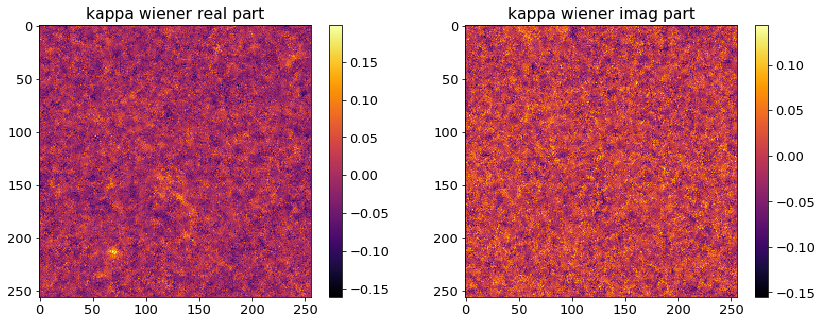

In [9]:
# plot the imaginary and real part of the wiener estimate 

resreal = fits.getdata('../build/rres.fits')
resimag = fits.getdata('../build/ires.fits')

fig5, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(resreal, interpolation='none', cmap='inferno' )
fig5.colorbar(cax1, ax = ax1), ax1.set_title('kappa wiener real part')
cax2 = ax2.imshow(resimag, interpolation='none', cmap='inferno')
fig5.colorbar(cax2, ax = ax2), ax2.set_title('kappa wiener imag part')

plt.show()

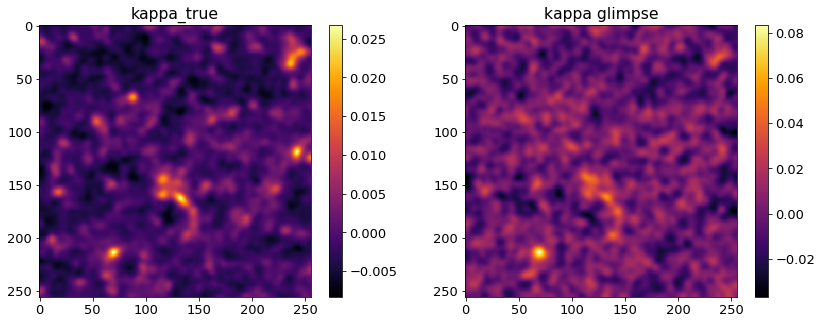

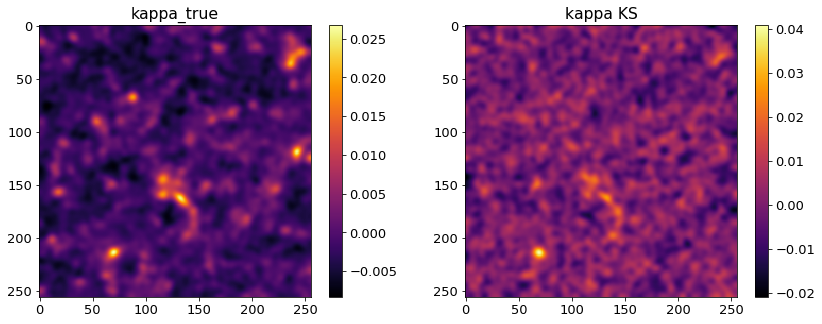

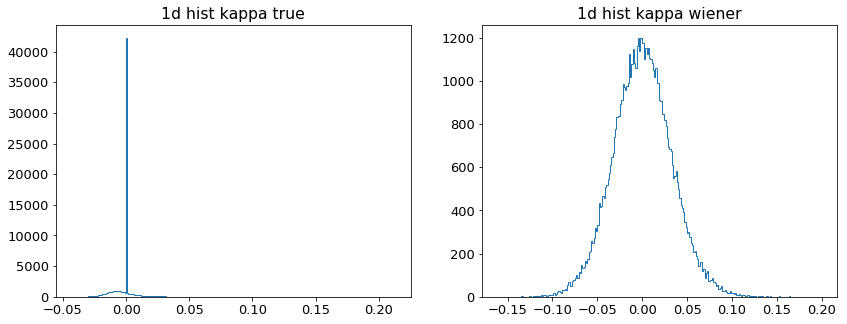

In [8]:
# compare true map with wiener result

krnl = 3
skwf = ndimage.filters.gaussian_filter(kwf, sigma = krnl)
skmt = ndimage.filters.gaussian_filter(kmt, sigma = krnl)
skks = ndimage.filters.gaussian_filter(kks, sigma = krnl)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(skmt, interpolation='none', cmap='inferno') 
ax1.set_title('kappa_true'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(skwf, interpolation='none', cmap='inferno')
ax2.set_title('kappa glimpse'), plt.colorbar(cax2, ax=ax2)

fig3, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(skmt, interpolation='none', cmap='inferno') 
ax1.set_title('kappa_true'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(skks.T, interpolation='none', cmap='inferno')
ax2.set_title('kappa KS'), plt.colorbar(cax2, ax=ax2)

fig2, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].hist(np.reshape(kmt,-1),bins=256, histtype = 'step')
ax[0].set_title('1d hist kappa true')
cax2 = ax[1].hist(np.reshape(kwf,-1),bins=256, histtype = 'step')
ax[1].set_title('1d hist kappa wiener')

plt.show()

## Debug info 



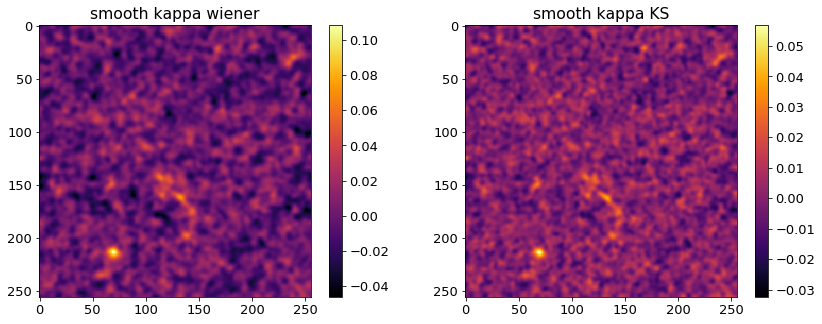

In [19]:
### smooth maps
krnl = 2
# skgs = ndimage.filters.gaussian_filter(kgs, sigma = krnl)
# skappa = ndimage.filters.gaussian_filter(np.nan_to_num(kappa_map_true), sigma = krnl)
# skgw = ndimage.filters.gaussian_filter(np.nan_to_num(kgw), sigma = krnl)
skks = ndimage.filters.gaussian_filter(kks, sigma = krnl)
skwf = ndimage.filters.gaussian_filter(np.nan_to_num(kwf), sigma = krnl)

# plot the smooth glimpse, wiener, glimpse+wiener maps
fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[1].imshow(skks.T, interpolation='none', cmap='inferno')
ax[1].set_title('smooth kappa KS'), plt.colorbar(cax1, ax=ax[1])
cax2 = ax[0].imshow(skwf, interpolation='none', cmap='inferno') 
ax[0].set_title('smooth kappa wiener'), plt.colorbar(cax2, ax=ax[0])

# fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(skwf, interpolation='none', cmap='inferno') 
# ax1.set_title('smooth kappa wiener'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(skks.T - skwf, interpolation='none', cmap='inferno') 
# ax2.set_title('kKS - kwf'), plt.colorbar(cax2, ax=ax2)

plt.show()


(182,)
48.3164473704


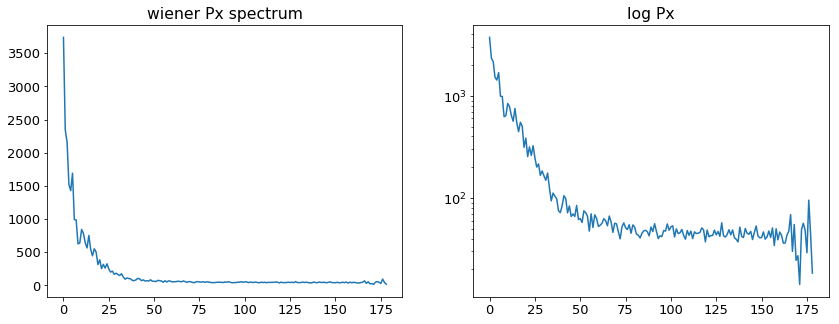

In [20]:
# power spectrum of wiener map


def radial_profile(data):
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    
    radialprofile = tbin / nr
    return radialprofile

fft2D = np.fft.fft2(kwf)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D_kwf = radial_profile(np.fft.fftshift(psd2D))

fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].plot(psd1D_kwf[1:180]), ax[0].set_title('wiener Px spectrum') 
cax2 = ax[1].plot(psd1D_kwf[1:180]), ax[1].set_title('log Px') , ax[1].set_yscale('log')
print(psd1D_kwf.shape)
print(psd1D_kwf[100])

(182,)
48.3164473704


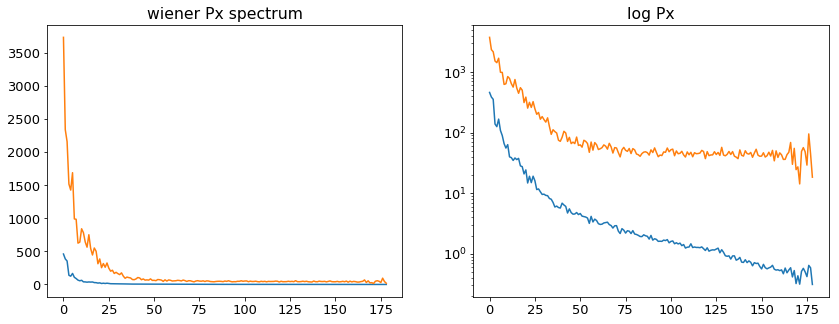

In [21]:
fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].plot(psd1D_skmt[1:180]), 
cax1 = ax[0].plot(psd1D_kwf[1:180])
ax[0].set_title('wiener Px spectrum') 
cax1 = ax[1].plot(psd1D_skmt[1:180]), 
cax1 = ax[1].plot(psd1D_kwf[1:180])
ax[1].set_title('wiener Px spectrum'), ax[1].set_title('log Px') , ax[1].set_yscale('log') 
# cax2 = ax[0].plot(psd1D_kwf[1:180]), ax[1].set_title('log Px') , ax[1].set_yscale('log')
print(psd1D_kwf.shape)
print(psd1D_kwf[100])

In [22]:
npix = 256 
impix = npix ** 2

ps0 = fits.getdata('../build/pst_000_1.fits') / impix
# ps1 = fits.getdata('../build/psx_005.fits') / impix
# ps2 = fits.getdata('../build/pst_005_2.fits') / impix
# ps3 = fits.getdata('../build/psx_010.fits') / impix
# ps4 = fits.getdata('../build/pst_010_2.fits') / impix

# fig1, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].plot(ps1), ax[0].set_title(r'spectrum of $\mathbf{x}_g$')
# ax[1].plot(ps2), ax[1].set_title(r'spectrum of $ \mathbf{H}^T \mathbf{H} \mathbf{x}_g$')
# plt.show()

# fig2, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].plot(ps1), ax[0].set_title(r'spectrum of $\mathbf{x}_g$ at $5$th iteration')
# ax[0].plot(ps2)
# ax[1].plot(ps1 - ps2), ax[1].set_title('difference')

# fig5, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].plot(ps3), ax[0].set_title(r'spectrum of $\mathbf{x}_g$ at $10$th iteration')
# ax[0].plot(ps4)
# ax[1].plot(ps3 - ps4), ax[1].set_title('difference')

fig3, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(ps0)
ax[0].plot(np.ones(ps0.shape))
ax[0].set_title(r'first iteration, spectrum of $\Sigma^{-1/2} \mathbf{y}$')
ax[1].plot(ps0)
ax[1].plot(np.ones(ps0.shape))
ax[1].set_title(r'... log-y-scale')
ax[1].set_yscale('log')
plt.show()

print('Mean of Pxg is', np.mean(ps0[:]))



FileNotFoundError: [Errno 2] No such file or directory: '../build/pst_000_1.fits'

In [26]:
# plot power spectra per iteration

# Niter = 300
# Pt1d = np.zeros((182,Niter))
# for i in np.arange(Niter):
#     fname = '../build/pst_%0.3d.fits' % i
#     Pt1d[:,i] = np.squeeze(fits.getdata(fname))

# 147.981762495
# 9.502116068 - from c++
# 31.821636501 - from c++
# 0.699300688 - from c++

if Mask:
    pmu = 718.057411157 * np.ones(182)
if not Noise:
    pmu = 0.699300688 * np.ones(182)
else:
    pmu = 31.821636501 * np.ones(182)
    
Pt1d = np.zeros((182,3))
Pt1d[:,0] = np.squeeze(fits.getdata('../build/pst_000.fits'))
Pt1d[:,1] = np.squeeze(fits.getdata('../build/pst_001.fits'))
Pt1d[:,2] = np.squeeze(fits.getdata('../build/pst_099.fits'))
Pr1d = np.zeros((182,3))
Pr1d[:,0] = np.squeeze(fits.getdata('../build/psr_000.fits'))
Pr1d[:,1] = np.squeeze(fits.getdata('../build/psr_001.fits'))
Pr1d[:,2] = np.squeeze(fits.getdata('../build/psr_099.fits'))
Px1d = np.zeros((182,3))
Px1d[:,0] = np.squeeze(fits.getdata('../build/psx_000.fits'))
Px1d[:,1] = np.squeeze(fits.getdata('../build/psx_001.fits'))
Px1d[:,2] = np.squeeze(fits.getdata('../build/psx_099.fits'))


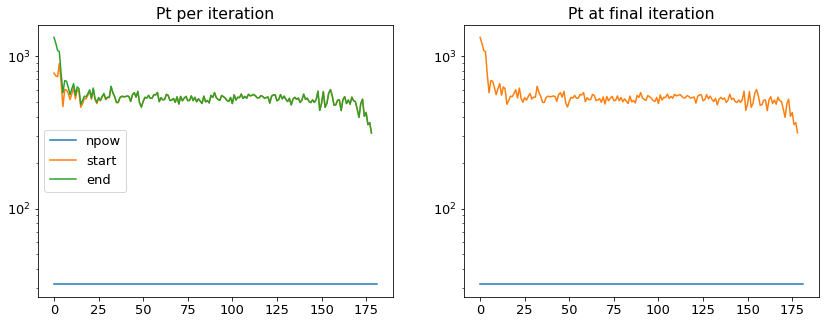

E[Pt] at final iteration:  526.538050843


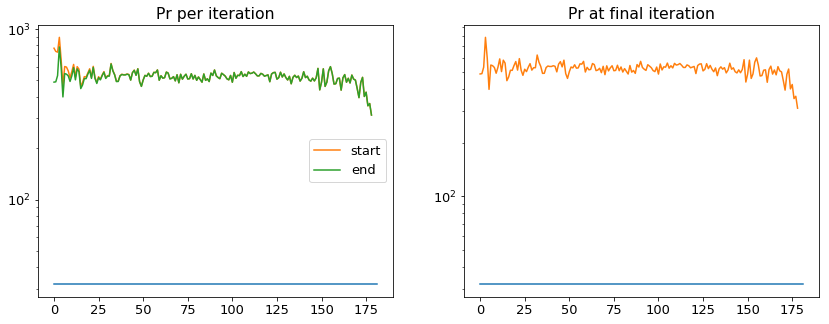

E[Pr] at final iteration  526.324371138


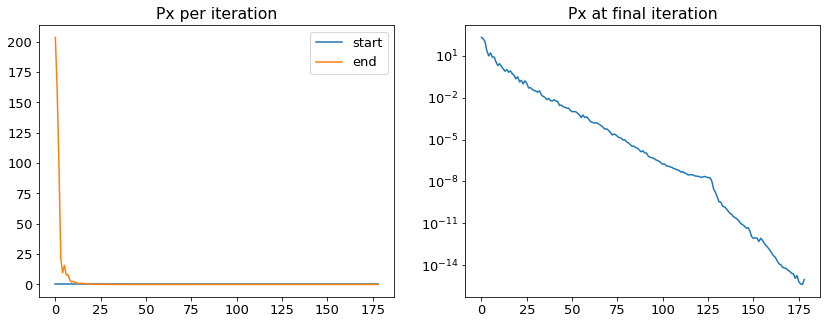

E[Px] at final iteration  9.0731979925e-05


In [27]:
fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
ax1.plot(pmu,label = 'npow'), ax1.plot(Pt1d[1:180,0],label = 'start'), ax1.set_title('Pt per iteration'), ax1.set_yscale('log')
ax1.plot(Pt1d[1:180,-1],label = 'end'), ax1.legend(), ax1.set_title('Pt per iteration')#, ax1.set_yscale('log')
ax2.plot(pmu,label = 'npow'), ax2.plot(Pt1d[1:180,-1]), ax2.set_title('Pt at final iteration'), ax2.set_yscale('log')
plt.show()

print('E[Pt] at final iteration: ', np.mean(Pt1d[50:150,-1]) )

fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
ax1.plot(pmu), ax1.plot(Pr1d[1:180,0],label = 'start'), ax1.set_title('Pr at first iteration'), ax1.set_yscale('log')
ax1.plot(Pr1d[1:180,-1],label = 'end'), ax1.legend(), ax1.set_title('Pr per iteration')#, ax1.set_yscale('log')
ax2.plot(pmu), ax2.plot(Pr1d[1:180,-1]), ax2.set_title('Pr at final iteration'), ax2.set_yscale('log')
plt.show()

print('E[Pr] at final iteration ', np.mean(Pr1d[50:150,-1]))
    
fig12, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
ax1.plot(Px1d[1:180,0], label = 'start'), ax1.set_title('Px at first iteration') #, ax1.set_yscale('log')
ax1.plot(Px1d[1:180,-1], label = 'end'), ax1.legend(), ax1.set_title('Px per iteration')#, ax1.set_yscale('log')
ax2.plot(Px1d[1:180,-1]), ax2.set_title('Px at final iteration'), ax2.set_yscale('log')

plt.show()

print('E[Px] at final iteration ', np.mean(Px1d[50:150,-1]))

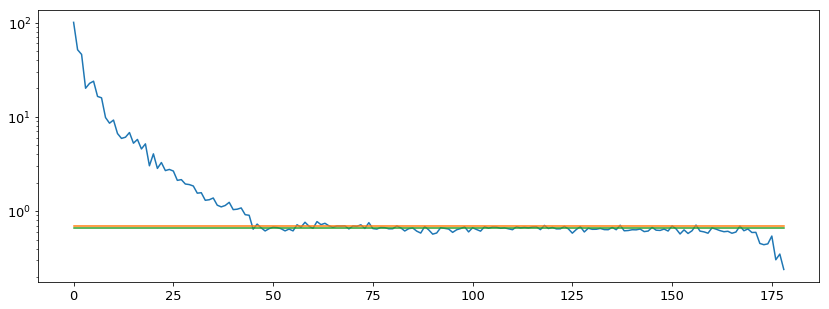

2.77793234642
0.658665994175


In [19]:
fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(Pr1d[1:180,0],label = 'Pr')
ax1.plot(pmu[1:180])
ax1.plot(np.mean(Pr1d[50:150,0]) * np.ones((179,1)))
ax1.set_yscale('log')
plt.show()

print(np.mean(Pr1d[:,0]))
print(np.mean(Pr1d[50:150,0]))


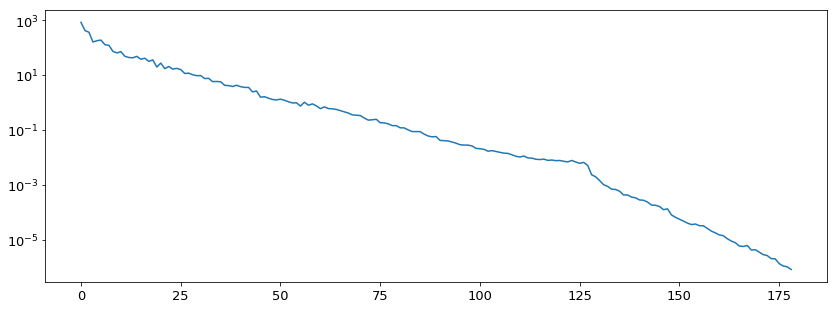

In [20]:
fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(np.abs(Pt1d[1:180,-1] - Pr1d[1:180,-1]),label = 'coef')
ax1.set_yscale('log')
plt.show()

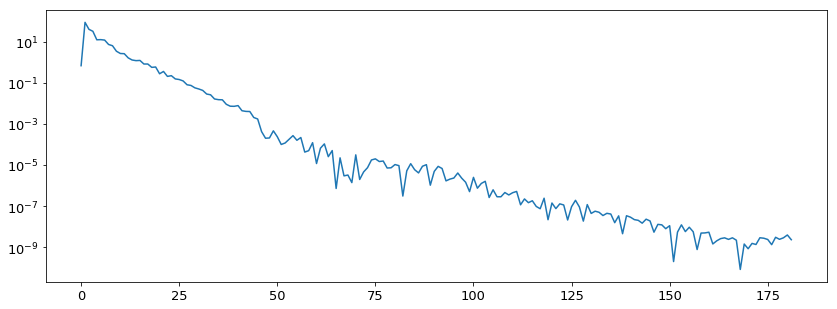

In [21]:
coef = np.zeros(182)
for i in range(182):
    coef[i] = .9**i

fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(coef * np.maximum(Pt1d[:,0] - pmu, pmu - Pr1d[:,0]) ,label = 'coef')
ax1.set_yscale('log')
plt.show()



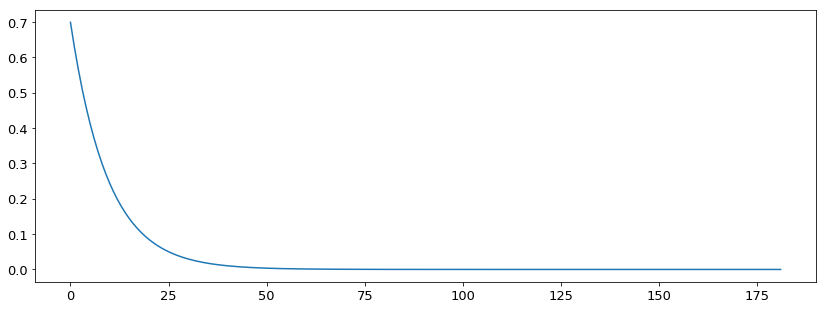

In [22]:
coef = np.zeros(182)
for i in range(182):
    coef[i] = .9**i
    
fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(( pmu) * coef ,label = 'coef')
# ax1.set_yscale('log')
plt.show()
    

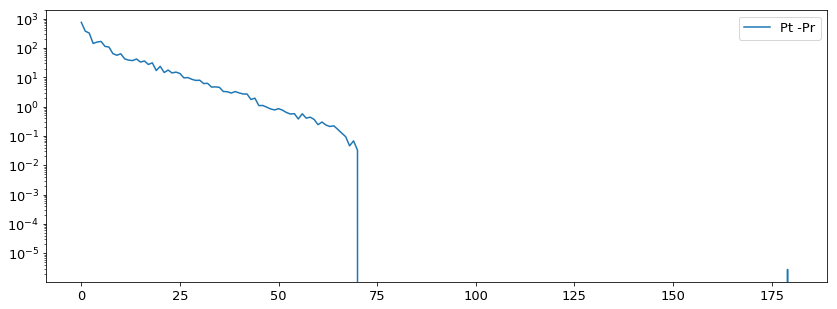

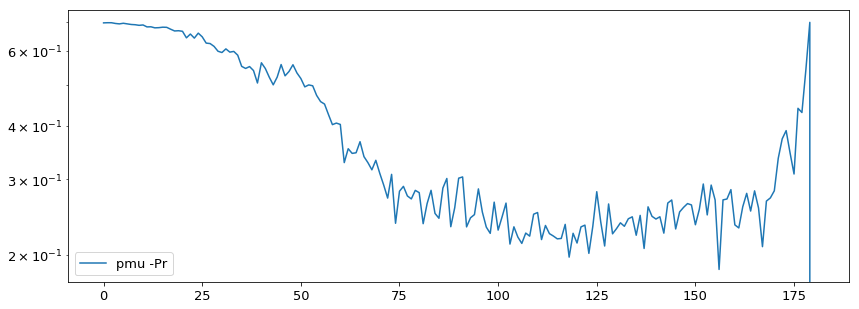

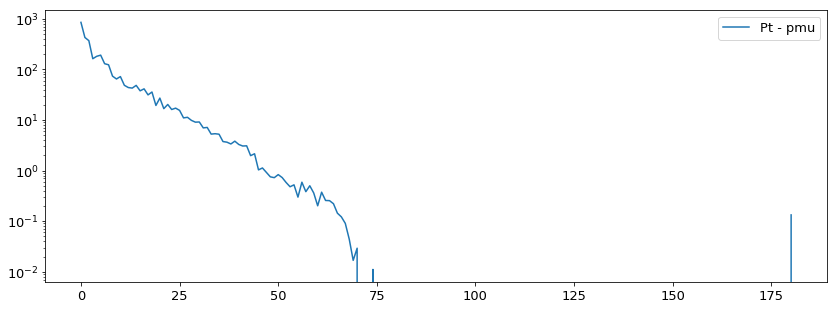

In [23]:
fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(Pt1d[1:,-1] - Pr1d[1:,0] ,label = 'Pt -Pr')
ax1.legend()
ax1.set_yscale('log')

fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(pmu[1:] - Pr1d[1:,-1] ,label = 'pmu -Pr')
ax1.legend(), ax1.set_yscale('log')

fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(Pt1d[1:,-1] - pmu[1:] ,label = 'Pt - pmu')
ax1.legend(), ax1.set_yscale('log')

plt.show()

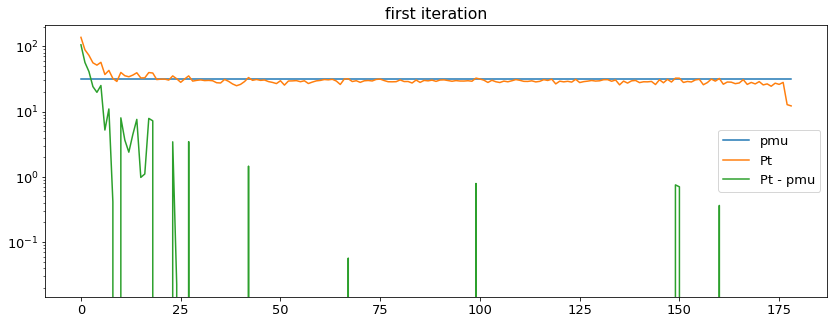

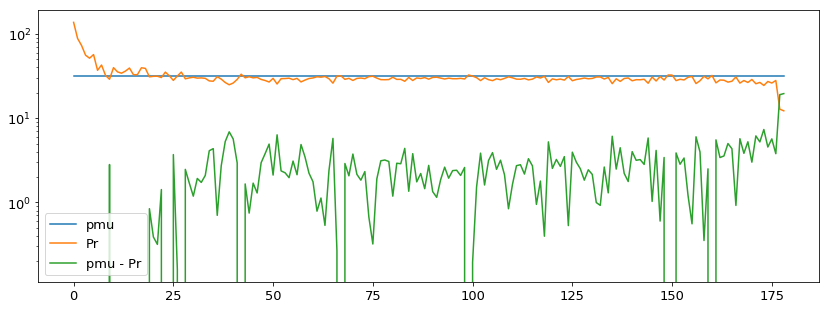

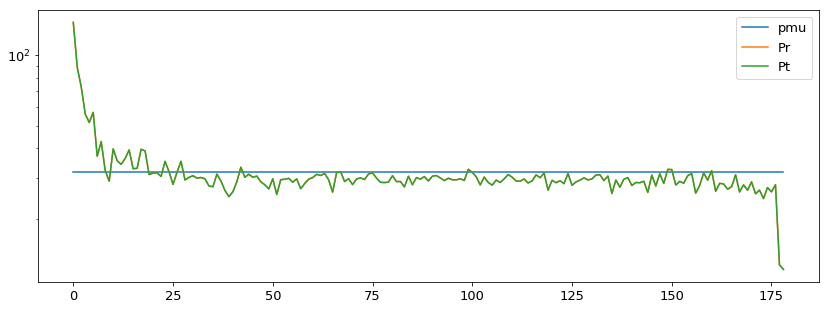

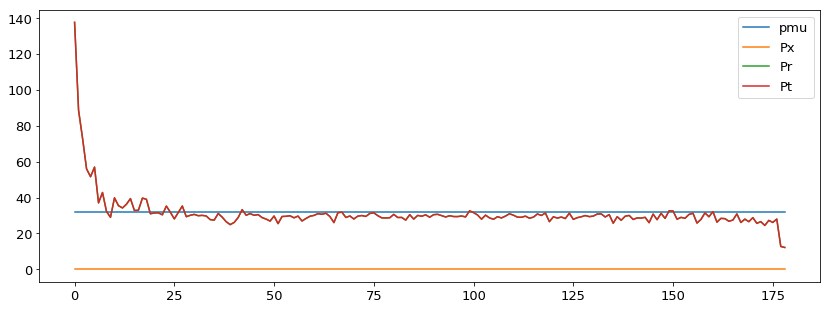

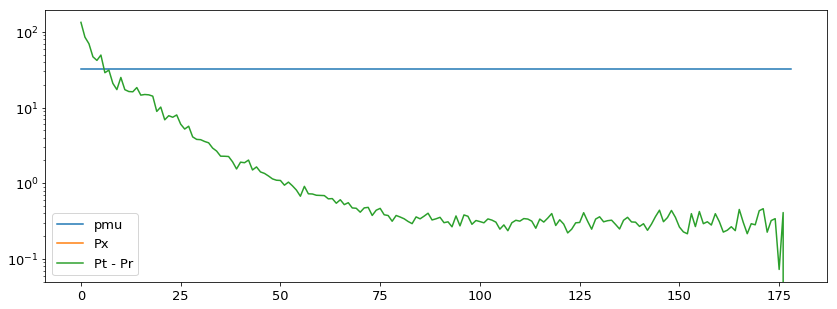

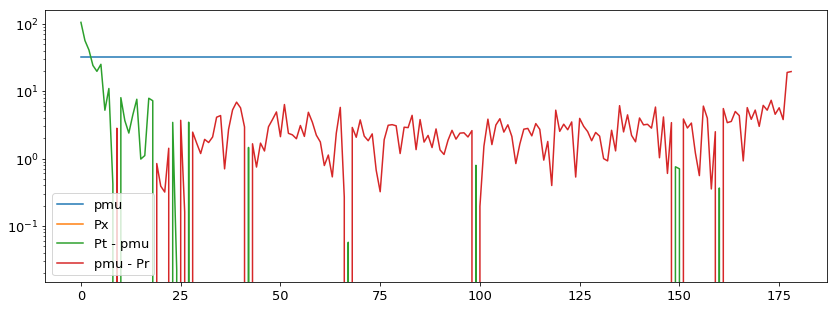

In [23]:
fig11, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(pmu[1:180],label = 'pmu')
ax1.plot(Pt1d[1:180,0],label = 'Pt')
ax1.plot(-pmu[1:180] + Pt1d[1:180,0],label = 'Pt - pmu'), ax1.legend(), ax1.set_title('first iteration'), ax1.set_yscale('log')

fig13, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(pmu[1:180],label = 'pmu')
ax1.plot(Pr1d[1:180,0],label = 'Pr')
ax1.plot(pmu[1:180] - Pr1d[1:180,0],label = 'pmu - Pr'), ax1.legend(), ax1.set_yscale('log')

fig14, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Pr1d[1:180,0],label = 'Pr')
ax2.plot(Pt1d[1:180,0],label = 'Pt'),ax2.legend(), ax2.set_yscale('log')

fig15, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,0],label = 'Px')
ax2.plot(Pr1d[1:180,0],label = 'Pr')
ax2.plot(Pt1d[1:180,0],label = 'Pt'),ax2.legend()
# ax2.plot(Px1d[1:180,0] + Pr1d[1:180,-1],label = 'Px + Pr'),ax2.legend(), ax2.set_yscale('log')

fig16, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,0],label = 'Px')
ax2.plot(Pt1d[1:180,0]- Pr1d[1:180,-1],label = 'Pt - Pr'),ax2.legend(), ax2.set_yscale('log')

fig17, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,0],label = 'Px')
ax2.plot(Pt1d[1:180,0] - pmu[1:180],label = 'Pt - pmu')
ax2.plot(pmu[1:180]- Pr1d[1:180,0],label = 'pmu - Pr'),ax2.legend(), ax2.set_yscale('log')

plt.show()

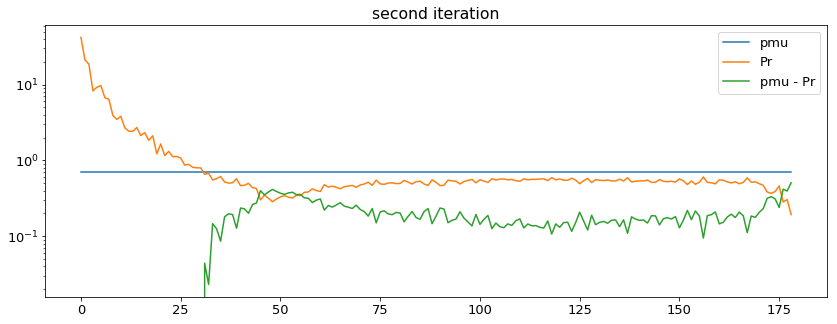

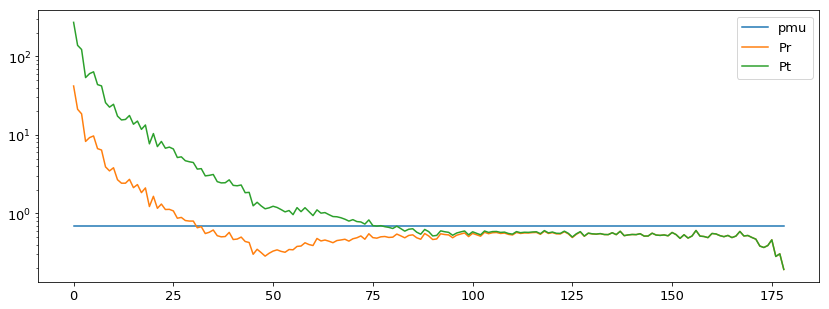

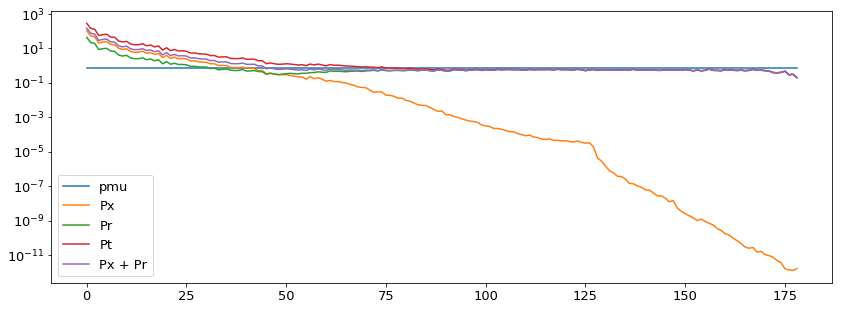

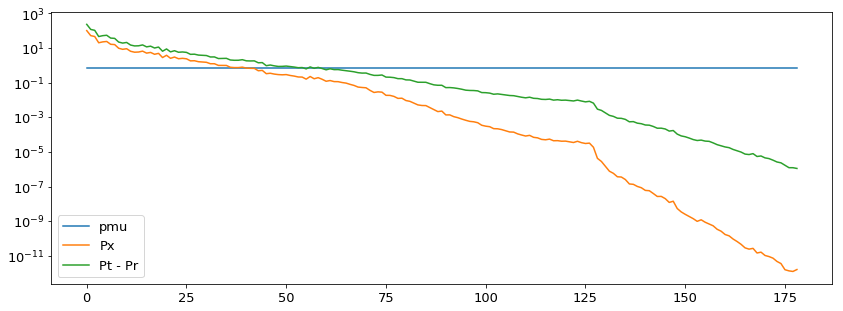

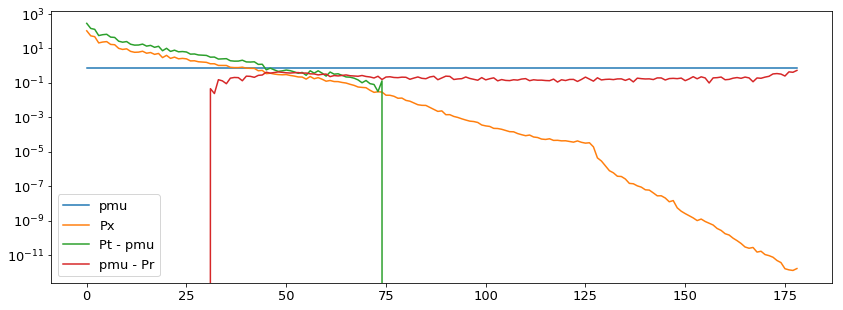

In [25]:
fig13, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(pmu[1:180],label = 'pmu')
ax1.plot(Pr1d[1:180,1],label = 'Pr')
ax1.plot(pmu[1:180] - Pr1d[1:180,1],label = 'pmu - Pr'), ax1.legend(), ax1.set_title('second iteration'), ax1.set_yscale('log')

fig14, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Pr1d[1:180,1],label = 'Pr')
ax2.plot(Pt1d[1:180,1],label = 'Pt'),ax2.legend(), ax2.set_yscale('log')

fig15, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,1],label = 'Px')
ax2.plot(Pr1d[1:180,1],label = 'Pr')
ax2.plot(Pt1d[1:180,1],label = 'Pt'),
ax2.plot(Px1d[1:180,1] + Pr1d[1:180,1],label = 'Px + Pr'),ax2.legend(), ax2.set_yscale('log')

fig16, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,1],label = 'Px')
ax2.plot(Pt1d[1:180,1]- Pr1d[1:180,1],label = 'Pt - Pr'),ax2.legend(), ax2.set_yscale('log')

fig17, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,1],label = 'Px')
ax2.plot(Pt1d[1:180,1] - pmu[1:180],label = 'Pt - pmu')
ax2.plot(pmu[1:180]- Pr1d[1:180,1],label = 'pmu - Pr'),ax2.legend(), ax2.set_yscale('log')

plt.show()

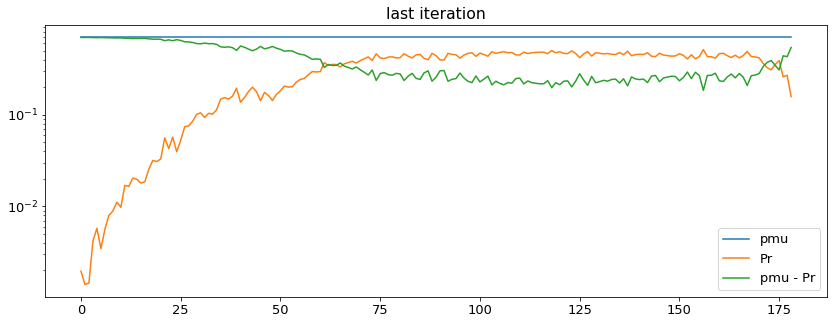

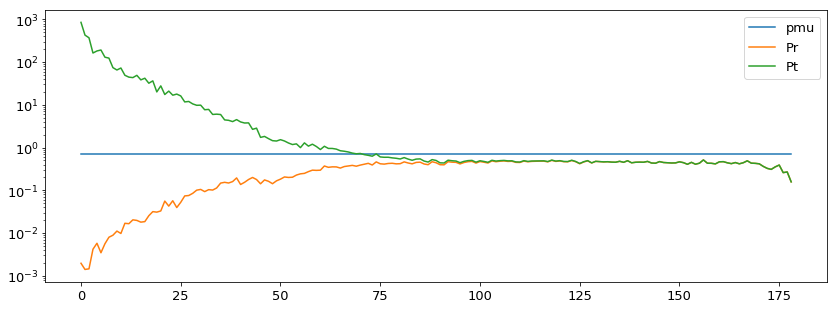

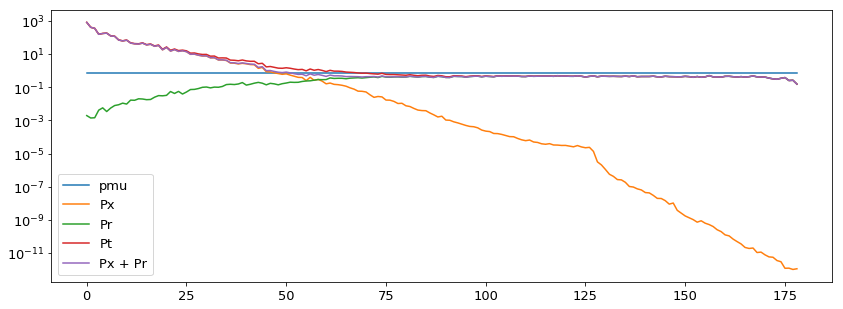

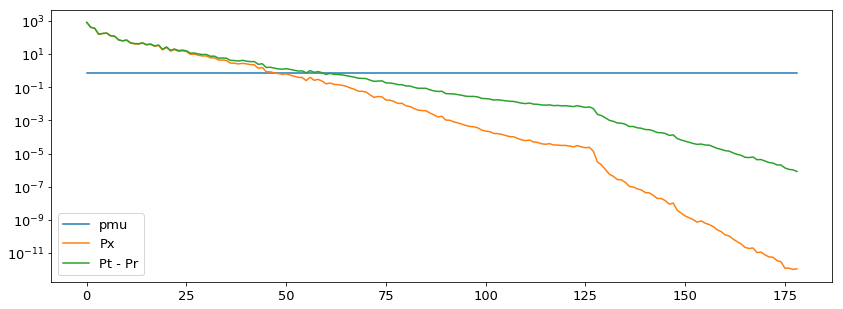

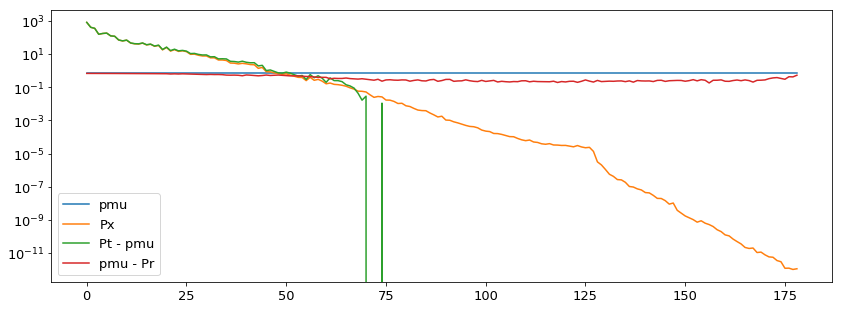

In [27]:
fig13, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(pmu[1:180],label = 'pmu')
ax1.plot(Pr1d[1:180,-1],label = 'Pr')
ax1.plot(pmu[1:180] - Pr1d[1:180,-1],label = 'pmu - Pr'), ax1.legend(), ax1.set_title('last iteration'), ax1.set_yscale('log')

fig14, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Pr1d[1:180,-1],label = 'Pr')
ax2.plot(Pt1d[1:180,-1],label = 'Pt'),ax2.legend(), ax2.set_yscale('log')

fig15, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,-1],label = 'Px')
ax2.plot(Pr1d[1:180,-1],label = 'Pr')
ax2.plot(Pt1d[1:180,-1],label = 'Pt'),
ax2.plot(Px1d[1:180,-1] + Pr1d[1:180,-1],label = 'Px + Pr'),ax2.legend(), ax2.set_yscale('log')

fig16, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,-1],label = 'Px')
ax2.plot(Pt1d[1:180,-1]- Pr1d[1:180,-1],label = 'Pt - Pr'),ax2.legend(), ax2.set_yscale('log')

fig17, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(pmu[1:180],label = 'pmu')
ax2.plot(Px1d[1:180,-1],label = 'Px')
ax2.plot(Pt1d[1:180,-1] - pmu[1:180],label = 'Pt - pmu')
ax2.plot(pmu[1:180]- Pr1d[1:180,-1],label = 'pmu - Pr'),ax2.legend(), ax2.set_yscale('log')

plt.show()

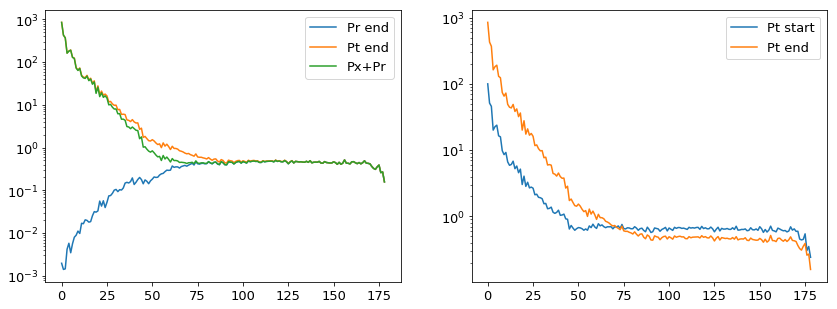

In [28]:
fig12, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# ax1.plot(Px1d[1:180,-1],label = 'Px'),
ax1.plot(Pr1d[1:180,-1],label = 'Pr end'),
ax1.plot(Pt1d[1:180,-1],label = 'Pt end'),
ax1.plot(Px1d[1:180,-1]+Pr1d[1:180,-1],label = 'Px+Pr'),
ax1.legend(), ax1.set_yscale('log')
ax2.plot(Pt1d[1:180,0],label = 'Pt start'),
ax2.plot(Pt1d[1:180,-1],label = 'Pt end'),
ax2.legend(), ax2.set_yscale('log')

plt.show()

In [24]:
# 8.640595636759169 - 8.6405774284966768

Pt1d[10,0]  - Pr1d[10,0] 

0.0

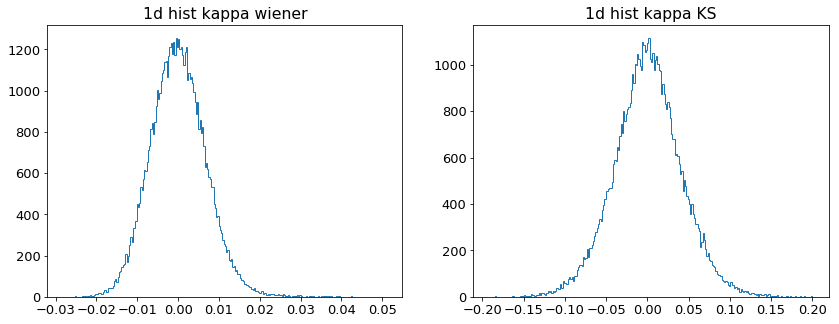

In [25]:
# plot the histogram of kappa

# fig1,ax = plt.subplots(nrows=1, ncols=2)
# cax0 = ax[0].hist(np.reshape(kappa_weighted,-1),bins=256, histtype = 'step')
# ax[0].set_title('1d hist kappa true')
# cax1 = ax[1].hist(np.reshape(kgw,-1),bins=256, histtype = 'step')
# ax[1].set_title('1d hist kappa proposed')


fig2,ax = plt.subplots(nrows=1, ncols=2)
cax0 = ax[0].hist(np.reshape(kwf,-1),bins=256, histtype = 'step')
ax[0].set_title('1d hist kappa wiener')
cax1 = ax[1].hist(np.reshape(kks,-1),bins=256, histtype = 'step')
ax[1].set_title('1d hist kappa KS')

plt.show()



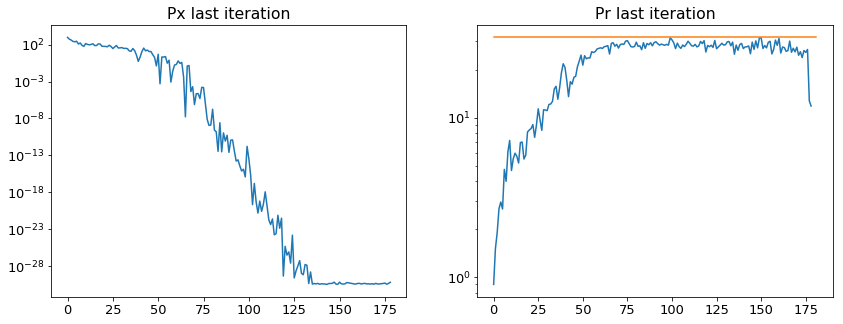

In [26]:

fig13, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(Px1d[1:180,-1]), ax[0].set_yscale('log'), ax[0].set_title('Px last iteration')
ax[1].plot(Pr1d[1:180,-1]), ax[1].set_yscale('log'), ax[1].set_title('Pr last iteration')
ax[1].plot(pmu)
plt.show()

In [27]:
# plot TSn 

# tsn = fits.getdata('../build/TSn.fits')

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# ax1.plot(Pr1d[:,0],label = 'Pr')
# ax1.plot(Pt1d[:,0],label = 'Pt')
# ax2.plot(tsn), ax2.set_title('TSn')
# plt.show()

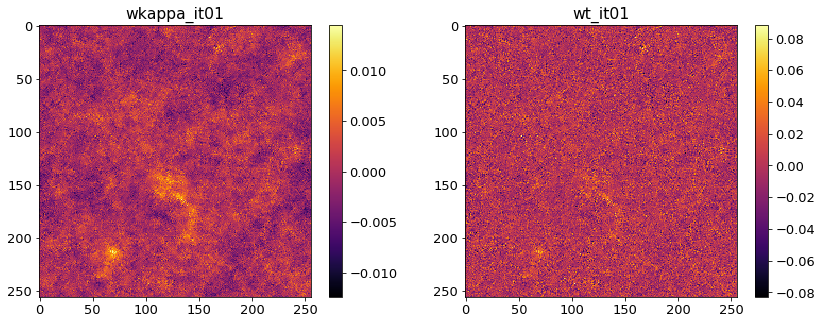

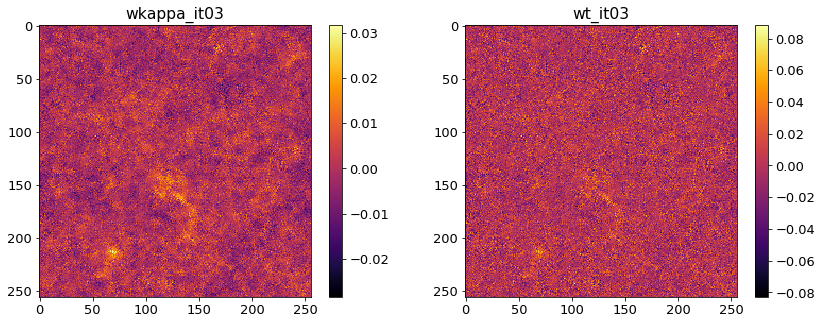

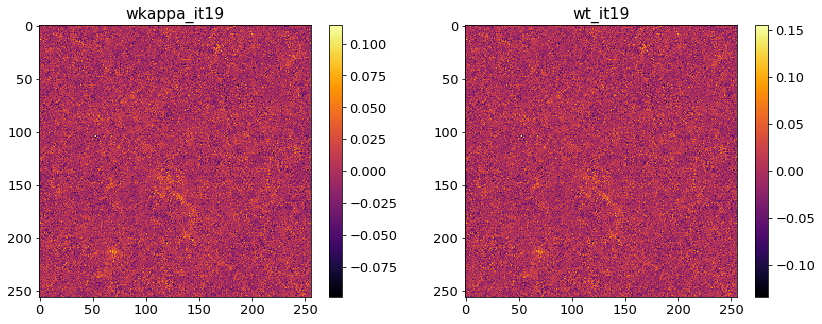

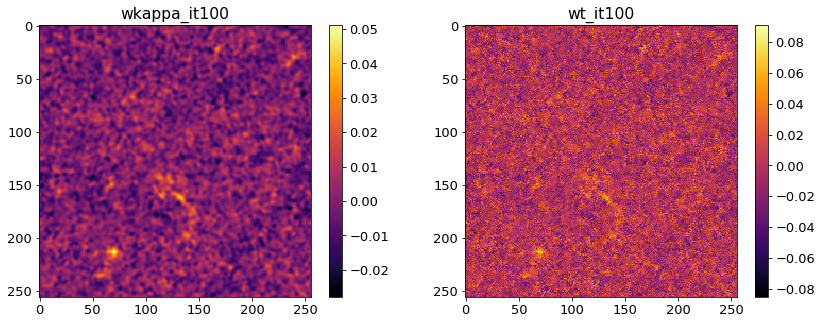

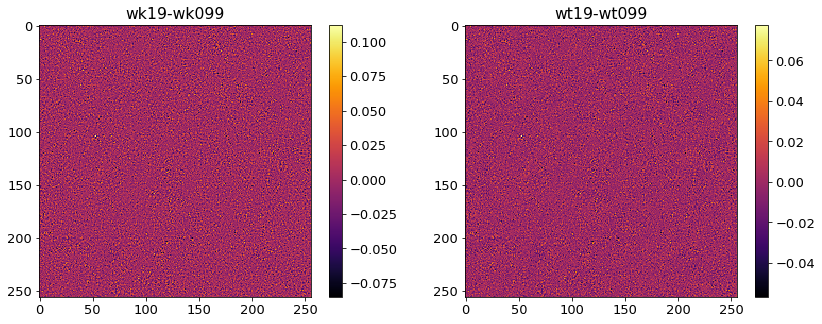

In [28]:
# check wiener convergence

wk1 = fits.getdata('../build/wkappa_001.fits')
wk3 = fits.getdata('../build/wkappa_003.fits')
wk19 = fits.getdata('../build/wkappa_019.fits')
wk099 = fits.getdata('../build/wkappa_099.fits')
wt1 = fits.getdata('../build/wt_003.fits')
wt3 = fits.getdata('../build/wt_003.fits')
wt19 = fits.getdata('../build/wt_019.fits')
wt099 = fits.getdata('../build/wt_099.fits')

fig5, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(wk1, interpolation='none', cmap='inferno' )
fig5.colorbar(cax1, ax = ax1), ax1.set_title('wkappa_it01')
cax2 = ax2.imshow(wt1, interpolation='none', cmap='inferno')
fig5.colorbar(cax2, ax = ax2), ax2.set_title('wt_it01')

fig6, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(wk3, interpolation='none', cmap='inferno' )
fig6.colorbar(cax1, ax = ax1), ax1.set_title('wkappa_it03')
cax2 = ax2.imshow(wt3, interpolation='none', cmap='inferno')
fig6.colorbar(cax2, ax = ax2), ax2.set_title('wt_it03')

fig7, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(wk19, interpolation='none', cmap='inferno' )
fig7.colorbar(cax1, ax = ax1), ax1.set_title('wkappa_it19')
cax2 = ax2.imshow(wt19, interpolation='none', cmap='inferno')
fig7.colorbar(cax2, ax = ax2), ax2.set_title('wt_it19')

fig8, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(wk099, interpolation='none', cmap='inferno' )
fig8.colorbar(cax1, ax = ax1), ax1.set_title('wkappa_it100')
cax2 = ax2.imshow(wt099, interpolation='none', cmap='inferno')
fig8.colorbar(cax2, ax = ax2), ax2.set_title('wt_it100')

fig9, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(wk19-wk099, interpolation='none', cmap='inferno' )
fig9.colorbar(cax1, ax = ax1), ax1.set_title('wk19-wk099')
cax2 = ax2.imshow(wt19-wt099, interpolation='none', cmap='inferno')
fig9.colorbar(cax2, ax = ax2), ax2.set_title('wt19-wt099')

plt.show()

In [22]:
# # check that real part of x_g is equal to kwiener

# fig7, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kwf, interpolation='none', cmap='inferno' )
# fig6.colorbar(cax1, ax = ax1), ax1.set_title('kwf')
# cax2 = ax2.imshow(wk3, interpolation='none', cmap='inferno')
# fig6.colorbar(cax2, ax = ax2), ax2.set_title('wk2')

# plt.show()

## Soapbox


In [23]:
a1 = np.random.normal(10,1,(3))

# print(a1)

A1 = np.diag(a1)
A1_inv = np.diag(1 / a1)
print('A1 = \n',A1)

print('inv(A1) = \n',A1_inv)

print()

print('l2_norm inv(A1) is ', np.linalg.norm(np.linalg.inv(A1),2))

print('solution', 1/np.min(np.diag(A1)))




A1 = 
 [[  9.87938694   0.           0.        ]
 [  0.          10.18877273   0.        ]
 [  0.           0.          10.242727  ]]
inv(A1) = 
 [[ 0.10122086  0.          0.        ]
 [ 0.          0.09814725  0.        ]
 [ 0.          0.          0.09763025]]

l2_norm inv(A1) is  0.101220855758
solution 0.101220855758


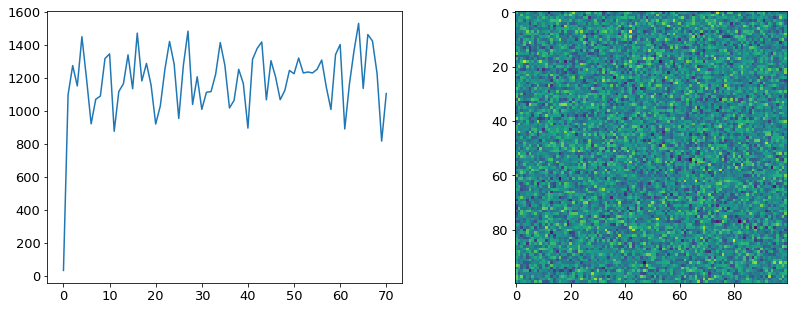

1184.32789988
1190.2499999999998


In [24]:
mu = .345

npix = 100
impix = npix**2

imc = np.random.normal(0,mu,(npix,npix))

fft2D = np.fft.fft2(imc)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D_imc = radial_profile(np.fft.fftshift(psd2D))

fig5, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
ax1.plot(psd1D_imc)
ax2.imshow(imc)
plt.show()

print(np.mean(psd1D_imc))
print(mu**2 * impix)

E[psd1D_v1] 266088.31545
E[psd1D_v2] 7278287.08368


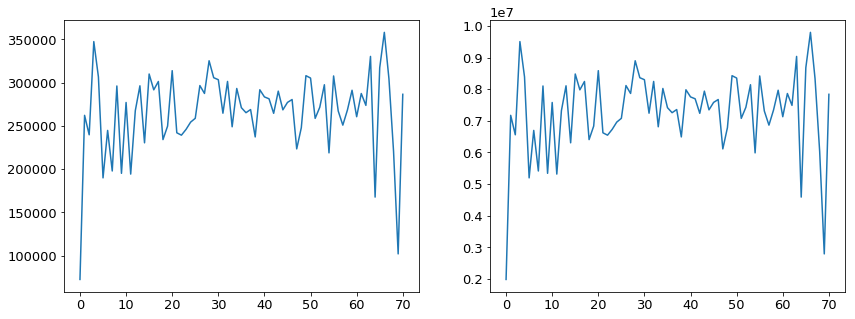

7481811.384100002


In [25]:
gamma = 5.23

# npix = 1000
# impix = npix ** 2
imc = np.random.normal(0,gamma,(npix,npix))

fft2D = np.fft.fft2(imc)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D_v1 = radial_profile(np.fft.fftshift(psd2D))

fft2D = np.fft.fft2(gamma * imc)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D_v2 = radial_profile(np.fft.fftshift(psd2D))

print('E[psd1D_v1]', np.mean(psd1D_v1))
print('E[psd1D_v2]', np.mean(psd1D_v2))

fig5, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
ax1.plot(psd1D_v1)
ax2.plot(psd1D_v2)
plt.show()

print(gamma**2 *gamma**2 * impix)

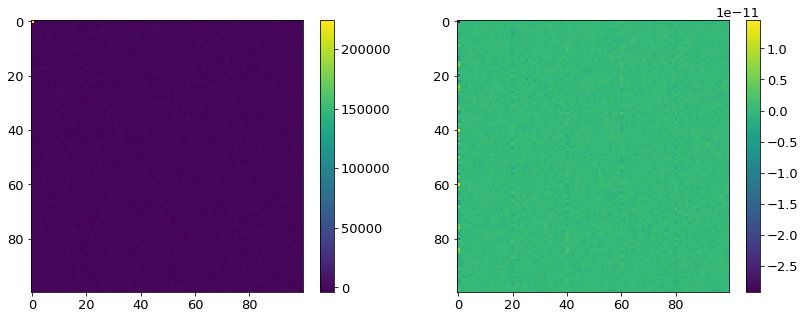

In [26]:

gamma = 5.6346
# npix = 1000
# impix = npix ** 2
imc = np.random.normal(4,2,(npix,npix))

fft2D1 = gamma * np.fft.fft2(imc)

fft2D2 = np.fft.fft2(gamma * imc )


fig5, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(np.real(fft2D1))
fig5.colorbar(cax1, ax = ax1)
cax2 = ax2.imshow(np.real(fft2D2) - np.real(fft2D1))
fig5.colorbar(cax2, ax = ax2)
plt.show()



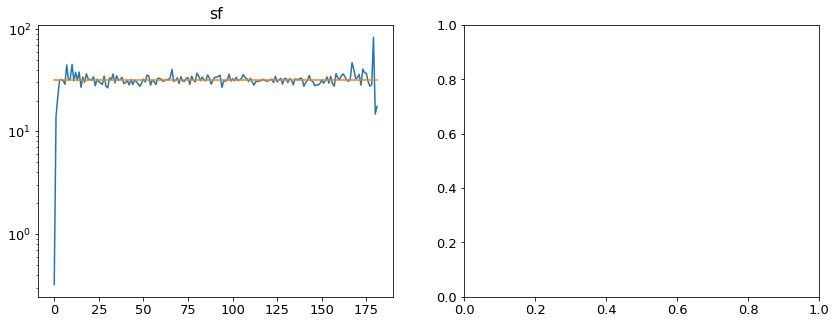

In [27]:
# power spectrum of an image

def radial_profile(data):
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    
    radialprofile = tbin / nr
    return radialprofile

nvar = .02212
npix = 256

n = np.random.normal(0,nvar,(npix,npix))

fft2D = np.fft.fft2(n)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D = radial_profile(np.fft.fftshift(psd2D)) 

fig1, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(psd1D), ax[0].set_title('sf'), ax[0].set_yscale('log')
ax[0].plot(nvar**2 * npix**2 * np.ones(psd1D.shape))
plt.show()



In [28]:
print(npix**2)

65536


In [29]:
print(np.sqrt(np.var(np.array([e1,e2]))))
print(np.pi)

0.0722466729628
3.141592653589793


In [30]:

# compute the noise variance of the shear using rotation
ngal = e1.shape[0]
theta1 = np.random.uniform(0, 2 * np.pi, ngal)
theta2 = np.random.uniform(0, 2 * np.pi, ngal)


e1r = e1 * np.cos(theta1) - e2 * np.sin(theta2)
e2r = e2 * np.cos(theta1) + e1 * np.sin(theta2)

print(np.sqrt(np.var(np.array([e1r,e2r]))))

0.0723985426991


Variance of trunc normal: 0.286120265107
(256, 256)


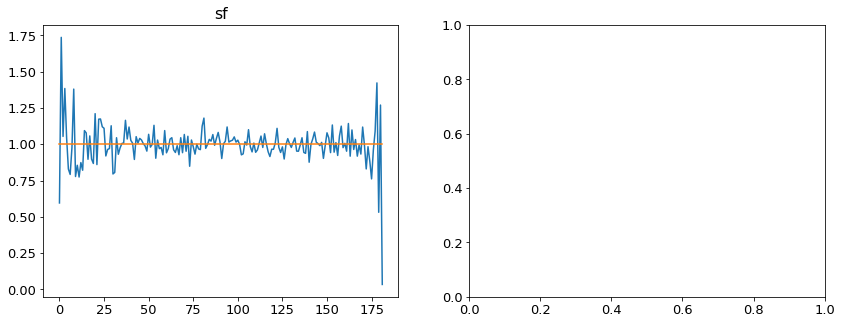

0.286


In [31]:
# power spectrum of image with truncated-normal-distributed noise

from scipy import stats

def radial_profile(data):
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    
    radialprofile = tbin / nr
    return radialprofile

npix = 256
sigma_epsilon_1 = .286

epsilon_1_noise = stats.truncnorm(-1.0/ sigma_epsilon_1,1.0/ sigma_epsilon_1,loc=0.0, scale=sigma_epsilon_1).rvs(npix**2)
imn = np.reshape(epsilon_1_noise,(npix, npix))

print('Variance of trunc normal:', np.sqrt(np.var(epsilon_1_noise)))

fft2D = np.fft.fft2(imn / sigma_epsilon_1)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D = radial_profile(np.fft.fftshift(psd2D)) / npix**2
print(imn.shape)

fig1, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(psd1D), ax[0].set_title('sf')#, ax[0].set_yscale('log')
ax[0].plot(np.ones(psd1D.shape))
plt.show()
print(sigma_epsilon_1)

(256, 256)


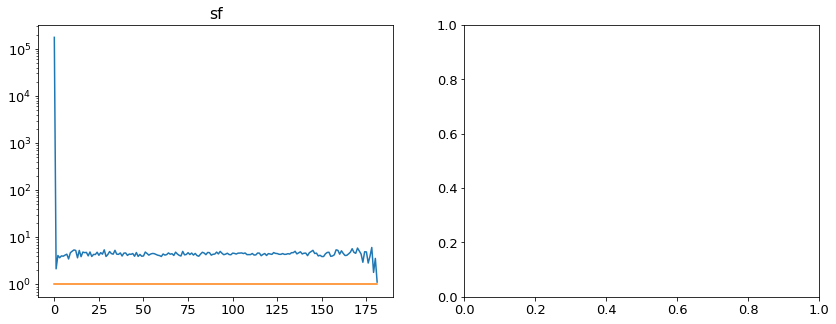

E[psd1D] = 4.46509298083


In [92]:
# generate log-normal noisy image


# Pr1d = np.zeros((182,Niter))
# for i in np.arange(Niter):
#     fname = '../build/psr_%0.3d.fits' % i
#     Pr1d[:,i] = np.squeeze(fits.getdata(fname))
    

    
imn = np.random.lognormal(0,1,(npix,npix))

fft2D = np.fft.fft2(imn)
psd2D = np.real(fft2D*np.conj(fft2D))
psd1D = radial_profile(np.fft.fftshift(psd2D)) / npix**2
print(imn.shape)

fig1, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(psd1D), ax[0].set_title('sf')#, ax[0].set_yscale('log')
ax[0].plot(np.ones(psd1D.shape))
ax[0].set_yscale('log')
plt.show()

print('E[psd1D] =', np.mean(psd1D[50:150]))

23930
(0,)
(41606,)


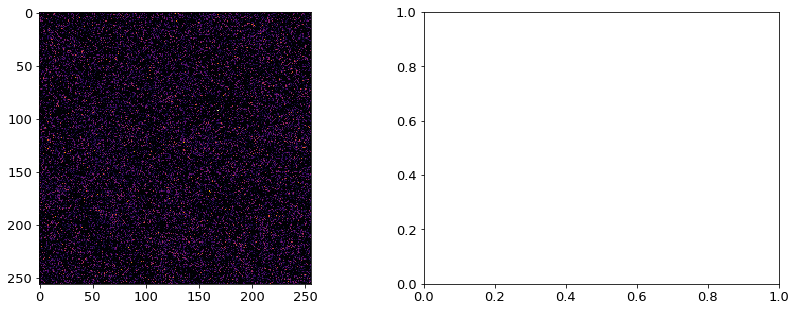

In [33]:
# check that noisy ellipticities fall in unit circle

imn = np.sqrt(g1_map_true**2 + g1_map_true**2)
fig1, ax = plt.subplots(nrows=1, ncols=2)
cax1 = ax[0].imshow(imn, interpolation='none', cmap='inferno')
# cax1 = ax[0].imshow(imn[imn>1], interpolation='none', cmap='inferno')

print(imn[imn<1].shape[0] - imn[imn==0].shape[0])
print(imn[imn>1].shape)
print(imn[imn==0].shape)

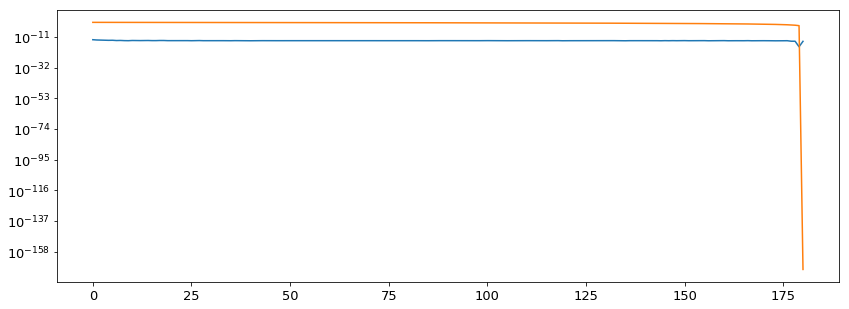

In [34]:
a1 = np.linspace(1e-170,1e-1,181)

fig1, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(Px1d[1:,-1])
ax.plot(a1[::-1])
ax.set_yscale('log')

In [35]:
Px1d[1:,-1].shape


(181,)

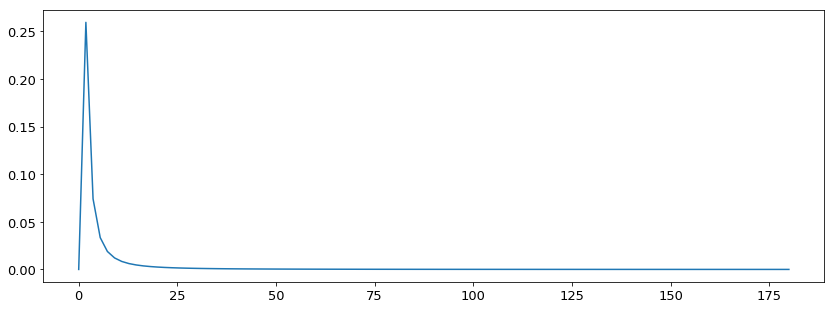

In [23]:
a1 = np.linspace(0,180,100)

plt.figure()
plt.plot(a1, a1 / (1+a1**3))